# Configuracion del entorno

In [1]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev==2.3.29
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from pathlib import Path

def plot_label_counts(dls):
    # Inicializar listas para etiquetas de training (originales y destiladas)
    train_original_labels = []
    train_distilled_labels = []

    # Recorrer cada ejemplo en el dataset de training
    for i in range(len(dls.train_ds)):
        label = int(dls.train_ds[i][1])
        # Obtener la ruta del archivo y extraer el nombre
        path = Path(dls.train_ds.items[i])
        filename = path.name.lower()  # convertir a minúsculas para evitar problemas con mayúsculas

        # Clasificar: si el nombre comienza con 'distilled', es destilado; de lo contrario, es original.
        if filename.startswith("distilled"):
            train_distilled_labels.append(label)
        else:
            train_original_labels.append(label)

    # Para validación, todas las imágenes se consideran originales
    valid_labels = [int(dls.valid_ds[i][1]) for i in range(len(dls.valid_ds))]

    # Contar el número de ejemplos por etiqueta en cada grupo
    train_orig_counts = Counter(train_original_labels)
    train_dist_counts = Counter(train_distilled_labels)
    valid_counts = Counter(valid_labels)

    # Obtenemos el vocabulario (lista de nombres de clases) y el número de clases:
    vocab = dls.vocab
    n_classes = len(vocab)

    # Crear listas de conteos para cada clase (asumiendo índices de 0 a n_classes-1)
    orig_data = [train_orig_counts[i] for i in range(n_classes)]
    dist_data = [train_dist_counts[i] for i in range(n_classes)]
    valid_data = [valid_counts[i] for i in range(n_classes)]

    # Configurar el gráfico de barras agrupadas:
    x = np.arange(n_classes)
    width = 0.25  # ancho de cada barra, para acomodar tres barras por etiqueta

    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(x - width, orig_data, width, label='Train Original', color='blue')
    ax.bar(x, dist_data, width, label='Train Distilled', color='red')
    ax.bar(x + width, valid_data, width, label='Valid', color='yellow')

    ax.set_ylabel('Número de elementos')
    ax.set_xticks(x)
    ax.set_xticklabels(vocab)
    ax.legend()

    plt.show()


# Apartado 1

Obtenemos los datos

In [4]:
os.environ["FASTAI_HOME"] = str(Path('/content/dataset'))

try:
  path = untar_data(URLs.MNIST)
except Exception as e:
  print(f"Error al descargar el dataset: {e}")


Lo ordenamos correctamente con los path

In [5]:
# Definir rutas para la organización
base_path = Path('/content/dataset')
original_path = base_path / "original"

original_path.mkdir(parents=True, exist_ok=True)

dest_original = original_path / path.name
if not dest_original.exists():
    shutil.move(str(path), str(dest_original))
    print(f"Dataset movido a: {dest_original}")
else:
    print("El dataset ya se encuentra en la carpeta original.")

Dataset movido a: /content/dataset/original/mnist_png


Montamos el drive para que tenga acceso

In [6]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## LENET

Creamos el datablock para lenet

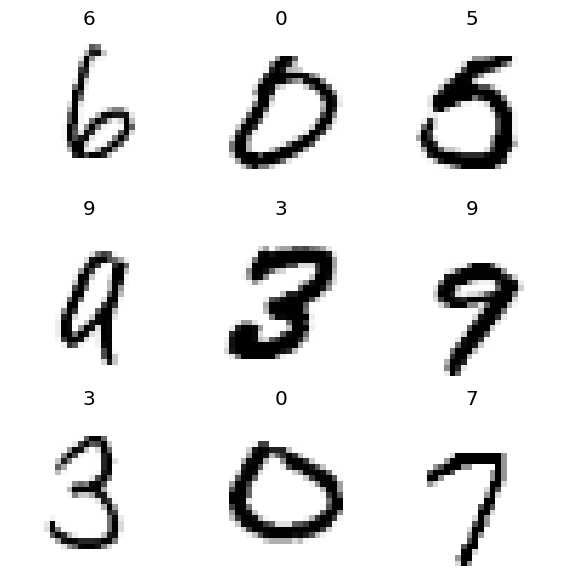

In [ ]:
# Crear los DataLoaders
blocks = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42)
)

# Crear los DataLoaders
dls = blocks.dataloaders(original_path/'mnist_png'/'training', bs=64)

# Mostrar una muestra de las imágenes para verificar la correcta organización
dls.show_batch(max_n=9, figsize=(7,7))


Número total de imágenes en entrenamiento: 48000
Número total de imágenes en validación: 12000

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


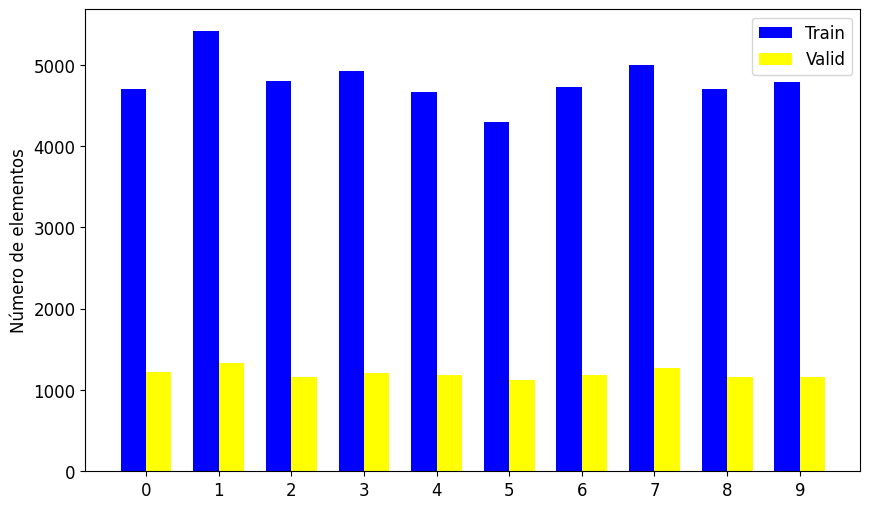

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class LeNet(nn.Module):
  def __init__(self, num_classes=10):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(16 * 4 * 4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = x.view(x.size(0), -1)  # Aplanar la salida
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

learn.summary()

LeNet (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 6 x 24 x 24    
Conv2d                                    156        True      
____________________________________________________________________________
                     64 x 16 x 8 x 8     
Conv2d                                    2416       True      
____________________________________________________________________________
                     64 x 16 x 4 x 4     
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 120            
Linear                                    30840      True      
____________________________________________________________________________
                     64 x 84             
Linear                                    10164      True      
____________________________________________________________

In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.735288,0.620867,0.823167,0.820863,0.820253,01:12
1,0.274359,0.258214,0.926667,0.927058,0.926433,01:10
2,0.148514,0.136256,0.959500,0.959408,0.959617,01:08
3,0.095400,0.093120,0.971250,0.971294,0.971258,01:19
4,0.067873,0.068851,0.977500,0.977489,0.977559,01:23
5,0.048141,0.064356,0.978750,0.978594,0.978670,01:12
6,0.050667,0.059294,0.981917,0.981875,0.982023,01:11
7,0.035519,0.059441,0.983417,0.983531,0.983389,01:10
8,0.021418,0.048728,0.985833,0.985783,0.985802,01:10
9,0.025082,0.043930,0.987667,0.987569,0.987646,01:25


No improvement since epoch 9: early stopping

Tiempo de entrenamiento: 989.56 segundos


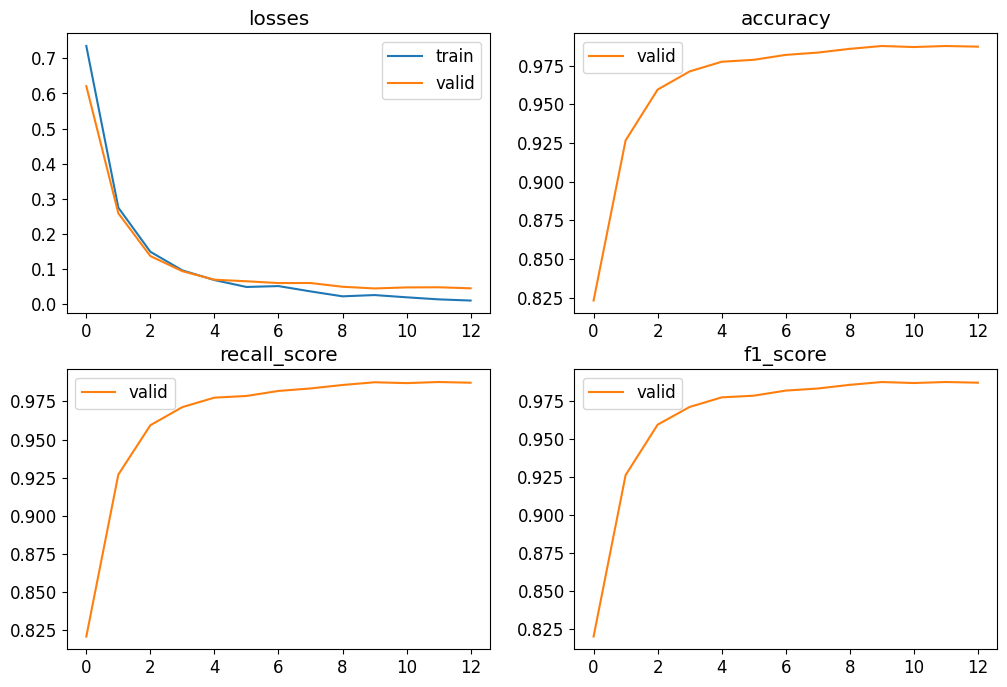

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0443
Accuracy: 0.9872
Recall: 0.9873
F1-Score: 0.9872


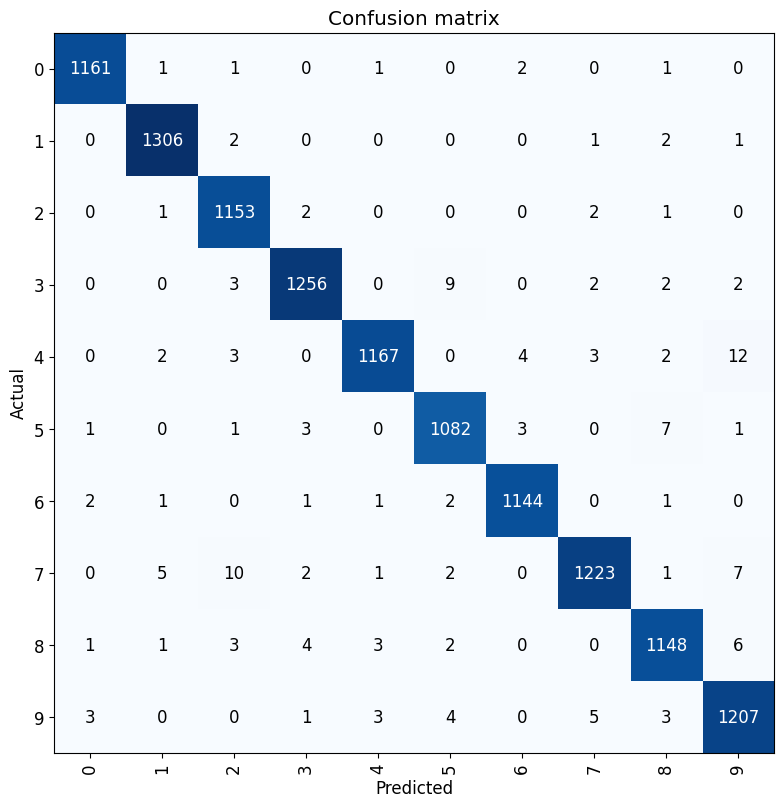

In [ ]:
#Creamos la interpretación de nuestro learner
interp = ClassificationInterpretation.from_learner(learn)

#Visualizamos la matriz de confusión
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_original_v3.pkl')

## Resnet

In [ ]:
original_path = Path("/content/dataset/original/mnist_png")

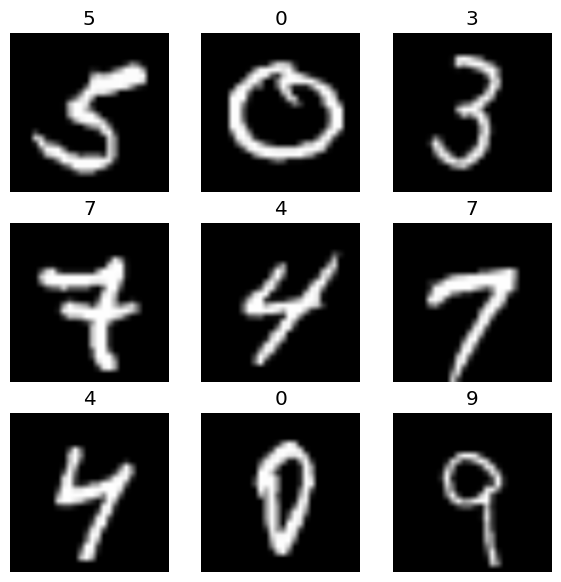

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    )

dls = dblock.dataloaders(original_path/'training', bs=64)

dls.show_batch(max_n=9, figsize=(7,7))


In [ ]:
# Crear el learner con resnet18
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])
learn.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

In [ ]:
# Entrenar el modelo
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.161515,0.193590,0.939500,0.939357,0.939042,03:20
1,0.100951,0.746685,0.819083,0.825968,0.825568,03:21
2,0.089116,0.076510,0.976167,0.976170,0.976047,03:20
3,0.064026,0.044403,0.985667,0.985289,0.985599,03:20
4,0.041279,0.066542,0.980000,0.979832,0.979937,03:22
5,0.035200,0.035214,0.989500,0.989509,0.989323,03:24
6,0.024800,0.030431,0.992667,0.992740,0.992603,03:21
7,0.022378,0.031668,0.991917,0.991872,0.991860,03:21
8,0.021128,0.035686,0.991750,0.991969,0.991725,03:20
9,0.017192,0.025730,0.993417,0.993454,0.993394,03:21


No improvement since epoch 10: early stopping

Tiempo de entrenamiento: 2818.79 segundos


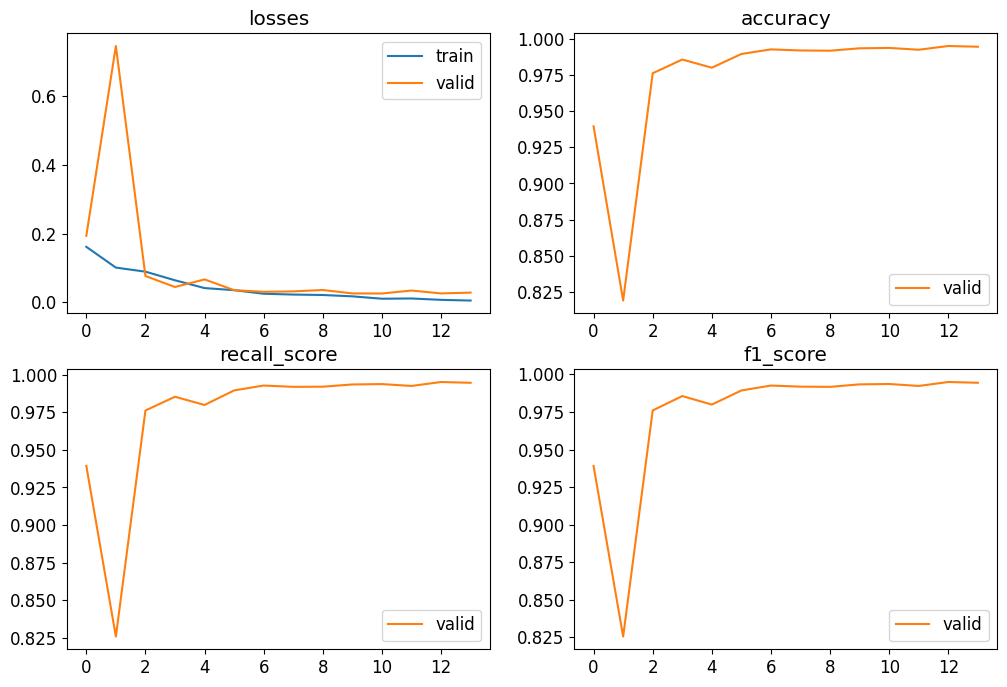

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0281
Accuracy: 0.9945
Recall: 0.9946
F1-Score: 0.9945


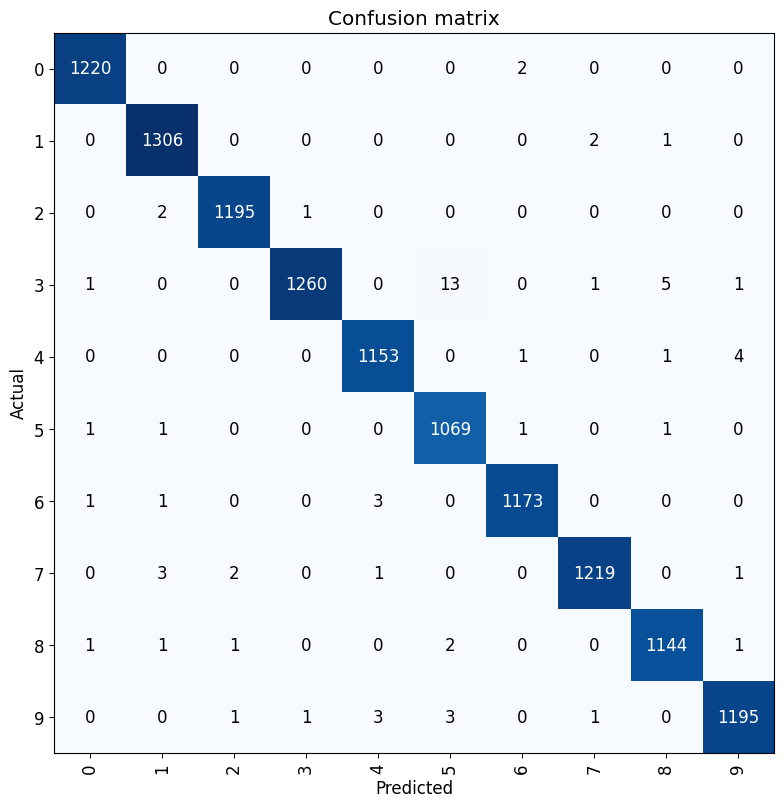

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=100)

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_original_v3.pkl')

# Apartado 2

## Destilacion de datos

In [7]:
original_path = base_path / "original"

mnist_001_path = base_path / "distilled_001"
mnist_001_path.mkdir(parents=True, exist_ok=True)

In [8]:
import random
import shutil
from pathlib import Path
import numpy as np
from PIL import Image

def media_arit(image_paths):
    avg_image = None
    count = 0
    # Sumar todas las imágenes (convertidas a array NumPy)
    for img_path in image_paths:
        with Image.open(img_path) as img:
            np_img = np.array(img, dtype=np.float32)
            if avg_image is None:
                avg_image = np_img
            else:
                avg_image += np_img
            count += 1
    # Calcular la media y convertir a uint8
    avg_image /= count
    avg_image = np.clip(avg_image, 0, 255).astype(np.uint8)
    return Image.fromarray(avg_image, mode='L')


In [9]:
def create_partial_distilled(src_path, dst_path, valid_ratio=0.2, distilled_portion=0.8, group_fraction=1, mix_function=media_arit):
    """
    Crea un nuevo dataset a partir de src_path con la siguiente estrategia:

      - Se divide en 80% training y 20% validación (valid_ratio).
      - En el conjunto de training:
          * El 80% de las imágenes se procesan mediante destilación usando mix_function.
          * El 20% restante se copia sin modificar.
      - En el conjunto de validación se copian las imágenes sin modificaciones.

    Parámetros:
      src_path: Ruta a la carpeta original, que debe tener subcarpetas para cada clase.
      dst_path: Ruta destino para el nuevo dataset.
      valid_ratio: Proporción de imágenes para validación (ej. 0.2 para 20%).
      distilled_portion: Proporción de imágenes dentro del training que serán destiladas (ej. 0.8 para 80%).
      group_fraction:
          * Si es 1, se mezclan todas las imágenes del subconjunto de destilación en una sola imagen.
          * Si es un valor entre 0 y 1, se agrupan en bloques cuyo tamaño es group_size = int(len(distilled_images) * group_fraction).
          * Si es 0, se procesa cada imagen individualmente (aunque normalmente querrás usar 1 o un valor intermedio).
      mix_function: Función que recibe una lista de rutas de imágenes y devuelve una imagen destilada.
    """
    src_path = Path(src_path)
    dst_path = Path(dst_path)

    # Eliminar dst_path si ya existe
    if dst_path.exists():
        shutil.rmtree(dst_path)
    dst_path.mkdir(parents=True, exist_ok=True)

    # Crear directorios para training y validación
    train_dst = dst_path / "training"
    valid_dst = dst_path / "valid"
    train_dst.mkdir(parents=True, exist_ok=True)
    valid_dst.mkdir(parents=True, exist_ok=True)

    # Procesar cada subcarpeta (clase) en src_path
    for class_dir in src_path.iterdir():
        if not class_dir.is_dir():
            continue

        images = list(class_dir.glob('*.*'))
        if not images:
            continue

        # Barajar y separar en training y validación
        random.shuffle(images)
        total = len(images)
        n_valid = int(total * valid_ratio)
        n_train = total - n_valid

        train_images = images[:n_train]
        valid_images = images[n_train:]

        # Dentro de training, separar el 80% para destilación y el 20% para copiar sin modificar
        n_train_distilled = int(n_train * distilled_portion)
        n_train_original = n_train - n_train_distilled

        distilled_images = train_images[:n_train_distilled]
        original_train_images = train_images[n_train_distilled:]

        # Crear subdirectorios para la clase en training y validación
        new_train_class_dir = train_dst / class_dir.name
        new_train_class_dir.mkdir(parents=True, exist_ok=True)
        new_valid_class_dir = valid_dst / class_dir.name
        new_valid_class_dir.mkdir(parents=True, exist_ok=True)

        # Procesar las imágenes para destilación (80% del conjunto de training)
        if group_fraction == 0:
            # Procesar cada imagen individualmente (aunque esto normalmente no es lo esperado)
            for img_path in distilled_images:
                distilled_img = mix_function([img_path])
                # Se guarda con el mismo nombre original
                new_file = new_train_class_dir / img_path.name
                distilled_img.save(new_file)
        elif group_fraction == 1:
            # Mezclar todas las imágenes del subconjunto en una sola imagen destilada
            distilled_img = mix_function(distilled_images)
            distilled_filename = new_train_class_dir / "distilled.jpg"
            distilled_img.save(distilled_filename)
        else:
            # Agrupar las imágenes en bloques
            group_size = max(1, int(len(distilled_images) * group_fraction))
            group_count = 0
            for i in range(0, len(distilled_images), group_size):
                group = distilled_images[i:i + group_size]
                distilled_img = mix_function(group)
                distilled_filename = new_train_class_dir / f"distilled_{group_count}.jpg"
                distilled_img.save(distilled_filename)
                group_count += 1

        # Copiar las imágenes originales (20% de training) sin modificar
        for img_path in original_train_images:
            shutil.copy(img_path, new_train_class_dir)

        # En validación se copian todas las imágenes sin procesar
        for img_path in valid_images:
            shutil.copy(img_path, new_valid_class_dir)


In [10]:
mnist_001_path = base_path / "distilled_001"
mnist_001_path.mkdir(parents=True, exist_ok=True)

create_partial_distilled(original_path/'mnist_png'/'training', mnist_001_path, valid_ratio=0.2, distilled_portion=0.8, group_fraction=0.01, mix_function=media_arit)


In [11]:
mnist_005_path = base_path / "distilled_005"
mnist_005_path.mkdir(parents=True, exist_ok=True)

create_partial_distilled(original_path/'mnist_png'/'training', mnist_005_path, valid_ratio=0.2, distilled_portion=0.8, group_fraction=0.05, mix_function=media_arit)


In [12]:
mnist_0001_path = base_path / "distilled_0001"
mnist_0001_path.mkdir(parents=True, exist_ok=True)

create_partial_distilled(original_path/'mnist_png'/'training', mnist_0001_path, valid_ratio=0.2, distilled_portion=0.8, group_fraction=0.001, mix_function=media_arit)


In [ ]:
def umbralizacion_tri(img: PILImage):
    return img.quantize(colors=3)

In [ ]:
def umbralizacion_bi(img: PILImage):
    return img.quantize(colors=2)

In [ ]:
import cv2

def otsu_threshold_transform(img: PILImage):
    #img_gray = img.convert("L")
    img_array = np.array(img)
    _, thresholded = cv2.threshold(img_array, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return PILImage.create(thresholded)

## Lenet 001 - v1

In [ ]:
dst = base_path / "distilled_001"

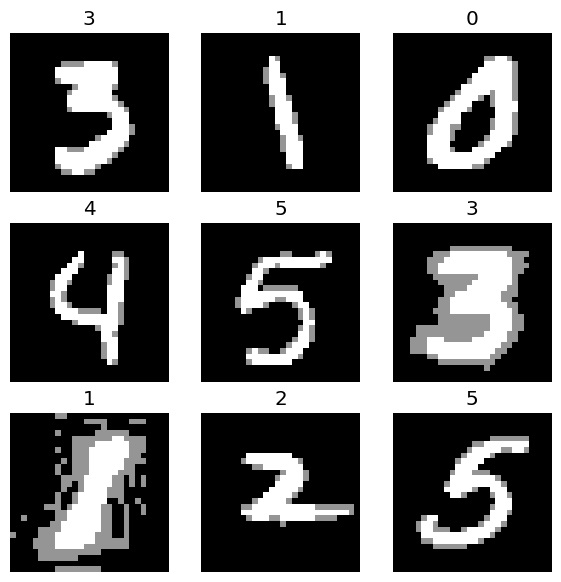

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[umbralizacion_tri]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 10622
Número total de imágenes en validación: 11996

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


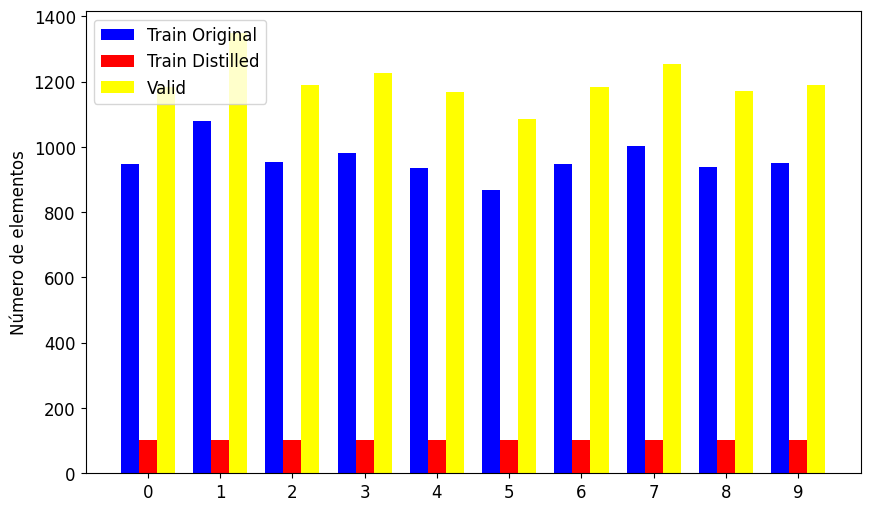

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.303637,2.302887,0.099116,0.100000,0.018036,00:32
1,2.302699,2.301589,0.112371,0.100000,0.020204,00:32
2,2.302465,2.301214,0.112371,0.100000,0.020204,00:35
3,2.206708,2.007974,0.296932,0.287527,0.203078,00:29
4,1.295534,0.997701,0.695982,0.691982,0.690974,00:22
5,0.724990,0.688867,0.771757,0.768889,0.766438,00:20
6,0.588648,0.604660,0.802768,0.799738,0.799430,00:22
7,0.535546,0.547255,0.825192,0.822788,0.820798,00:21
8,0.467272,0.486345,0.845699,0.843164,0.843265,00:22
9,0.439698,0.448082,0.858369,0.857346,0.856239,00:22



Tiempo de entrenamiento: 480.53 segundos


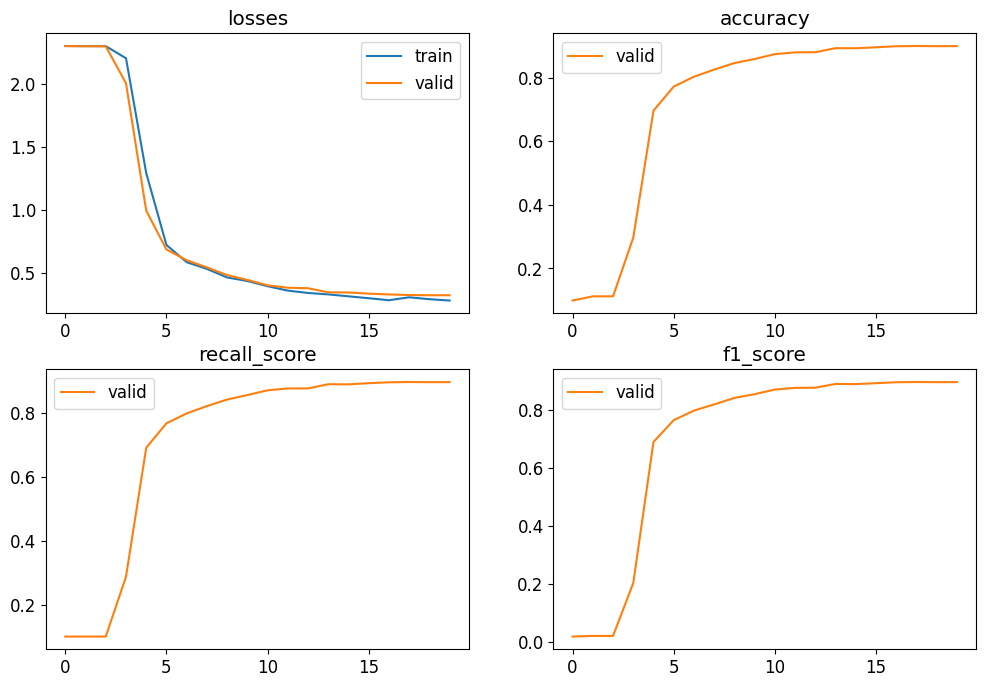

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.3263
Accuracy: 0.8990
Recall: 0.8979
F1-Score: 0.8980


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral01_001_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[umbralizacion_tri]
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral01_001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.31174930930137634
Accuracy: 0.9056490659713745
Recall (macro): 0.9044370230780082
F1 Score (macro): 0.9044216915625111


### Lenet 001 - Example 2

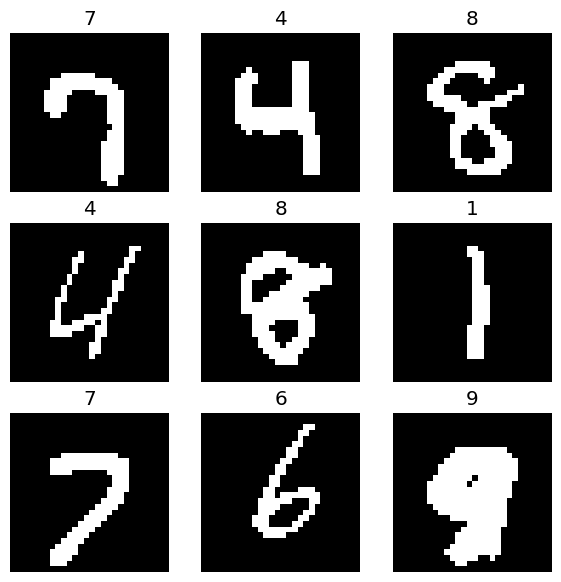

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[umbralizacion_bi]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.302307,2.302054,0.104451,0.100000,0.018915,00:33
1,2.302455,2.301394,0.112371,0.100000,0.020204,00:37
2,2.302010,2.301304,0.112371,0.100000,0.020204,00:32
3,2.302355,2.301293,0.112371,0.100000,0.020204,00:34
4,2.301176,2.298477,0.112371,0.100000,0.020204,00:32
5,1.993890,1.773674,0.396299,0.388357,0.324725,00:35
6,1.486556,1.435397,0.486829,0.479026,0.436658,00:32
7,1.275187,1.252673,0.561187,0.554655,0.534651,00:32
8,1.100647,1.105878,0.626459,0.621719,0.614363,00:34
9,0.987513,0.985897,0.657969,0.651855,0.643717,00:32



Tiempo de entrenamiento: 574.59 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.7159
Accuracy: 0.7578
Recall: 0.7544
F1-Score: 0.7533


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral02_001_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[umbralizacion_bi]
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral02_001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.700644314289093
Accuracy: 0.7682291865348816
Recall (macro): 0.765431187006854
F1 Score (macro): 0.7645344985195537


### Lenet 001 - Example 3

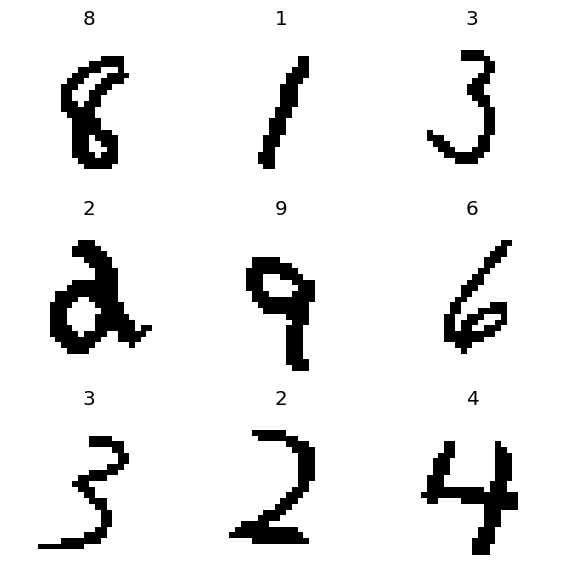

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[otsu_threshold_transform]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.275276,2.238251,0.355118,0.344102,0.256538,00:23
1,1.081598,0.743695,0.753918,0.748011,0.744747,00:22
2,0.469921,0.411546,0.877126,0.876669,0.876380,00:24
3,0.303166,0.323339,0.900717,0.899324,0.899736,00:24
4,0.224692,0.244451,0.920974,0.920468,0.920534,00:22
5,0.175758,0.182837,0.943481,0.942702,0.943148,00:23
6,0.141065,0.140015,0.955735,0.955309,0.955580,00:22
7,0.116545,0.126096,0.961987,0.961464,0.961788,00:23
8,0.096897,0.116470,0.965155,0.964873,0.964940,00:23
9,0.081490,0.106382,0.967573,0.967346,0.967286,00:22



Tiempo de entrenamiento: 466.81 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0876
Accuracy: 0.9755
Recall: 0.9753
F1-Score: 0.9753


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral03_001_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[otsu_threshold_transform]
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral03_001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.06906985491514206
Accuracy: 0.9790664911270142
Recall (macro): 0.9788967724027164
F1 Score (macro): 0.9789210614225704


## Lenet 005

In [ ]:
dst = base_path / "distilled_005"

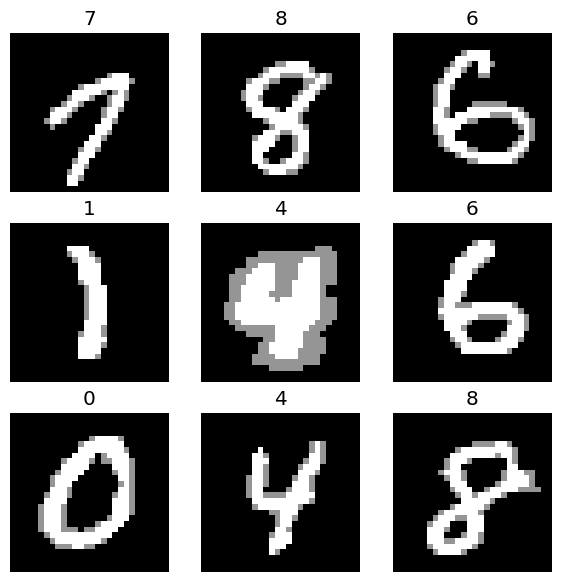

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[umbralizacion_tri]

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 9814
Número total de imágenes en validación: 11996

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


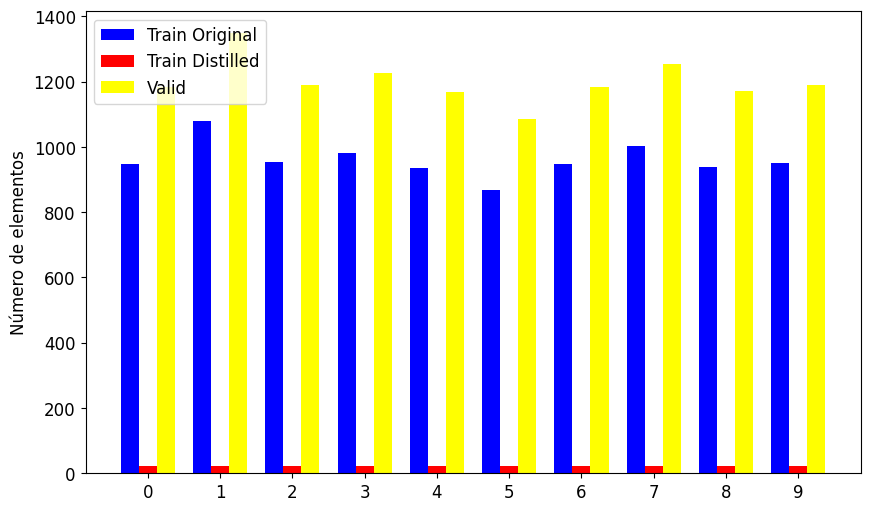

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.303652,2.303537,0.097533,0.100000,0.017773,00:20
1,2.302499,2.301883,0.112371,0.100000,0.020204,00:21
2,2.302171,2.301432,0.112371,0.100000,0.020204,00:20
3,2.302316,2.301395,0.112371,0.100000,0.020204,00:21
4,2.300755,2.299771,0.112371,0.100000,0.020204,00:20
5,1.577737,1.003974,0.700233,0.693959,0.688485,00:21
6,0.757389,0.644935,0.799933,0.796820,0.797194,00:20
7,0.601095,0.545369,0.830027,0.827172,0.827462,00:21
8,0.522456,0.488104,0.851117,0.848615,0.849045,00:20
9,0.466175,0.437676,0.858119,0.856143,0.854652,00:21



Tiempo de entrenamiento: 419.12 segundos


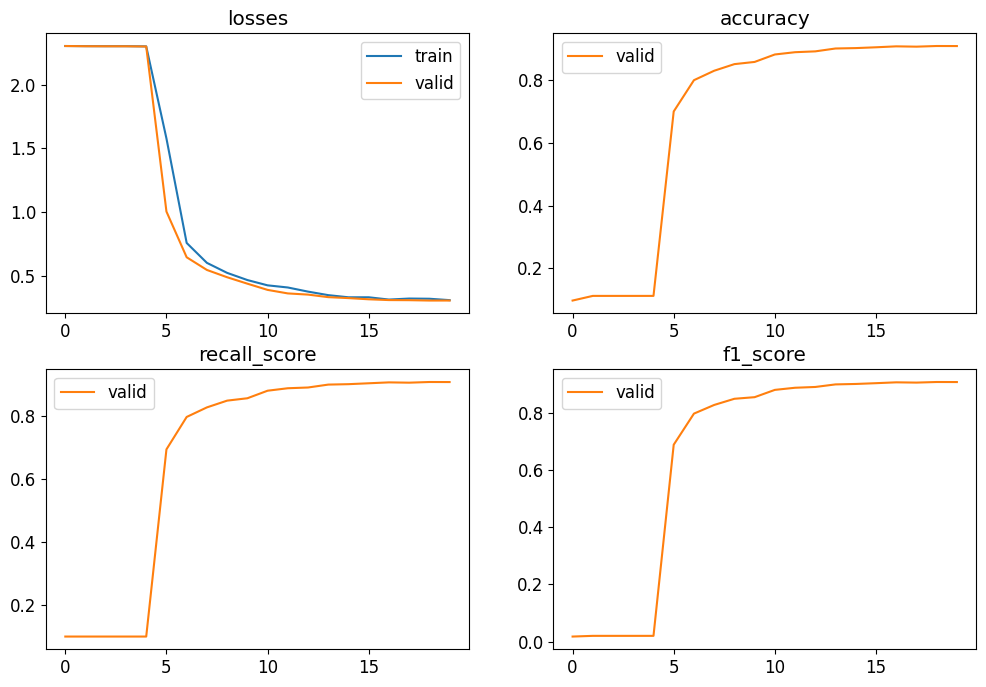

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.3052
Accuracy: 0.9087
Recall: 0.9076
F1-Score: 0.9075


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral01_005_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[umbralizacion_tri]
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral01_005_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.2963210940361023
Accuracy: 0.9106570482254028
Recall (macro): 0.9094546865251196
F1 Score (macro): 0.909363108512661


### Lenet 005 - Example 2

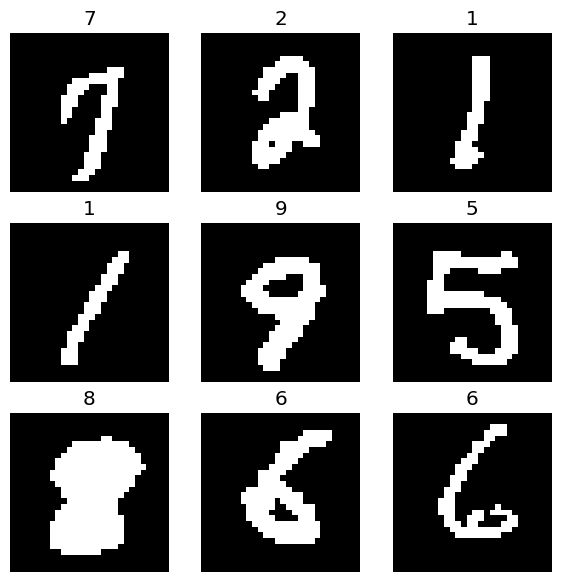

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[umbralizacion_bi]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.303406,2.302821,0.098700,0.100000,0.017967,00:22
1,2.302069,2.301266,0.112371,0.100000,0.020204,00:20
2,2.301937,2.301370,0.112371,0.100000,0.020204,00:22
3,2.302168,2.301577,0.112371,0.100000,0.020204,00:20
4,2.302082,2.300744,0.112371,0.100000,0.020204,00:22
5,2.059064,1.666552,0.440397,0.431153,0.366689,00:20
6,1.126482,0.970742,0.679143,0.671626,0.666600,00:22
7,0.887964,0.863228,0.706736,0.699997,0.696947,00:21
8,0.814973,0.787873,0.740830,0.737085,0.734848,00:21
9,0.756440,0.763879,0.754251,0.751054,0.748994,00:22



Tiempo de entrenamiento: 431.53 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.5844
Accuracy: 0.8184
Recall: 0.8159
F1-Score: 0.8157


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral02_005_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[umbralizacion_bi]
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral02_005_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.5746224522590637
Accuracy: 0.8138020634651184
Recall (macro): 0.8108760144567535
F1 Score (macro): 0.8105709833071811


### Lenet 005 - Example 3

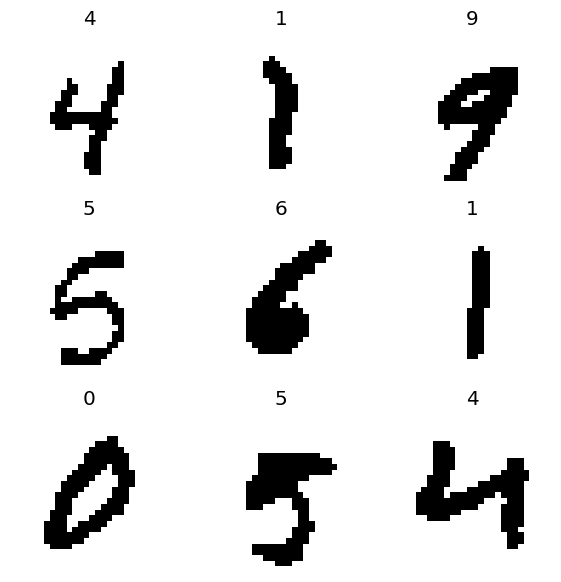

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[otsu_threshold_transform]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.285937,2.255917,0.229827,0.224599,0.130280,00:21
1,1.175439,0.667343,0.780677,0.774621,0.770004,00:23
2,0.456608,0.343555,0.895799,0.894467,0.894704,00:23
3,0.275450,0.236881,0.927726,0.926486,0.927364,00:22
4,0.191387,0.164008,0.949400,0.949056,0.949163,00:23
5,0.152447,0.125115,0.960487,0.960119,0.960132,00:22
6,0.119621,0.105656,0.968406,0.968089,0.968228,00:22
7,0.104566,0.090402,0.971657,0.971646,0.971444,00:23
8,0.086883,0.095655,0.970657,0.970677,0.970369,00:21
9,0.070320,0.087228,0.972491,0.972302,0.972228,00:23



Tiempo de entrenamiento: 460.19 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0730
Accuracy: 0.9787
Recall: 0.9786
F1-Score: 0.9785


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral03_005_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[otsu_threshold_transform]
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral03_005_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.05920115485787392
Accuracy: 0.9806690812110901
Recall (macro): 0.9805548641654174
F1 Score (macro): 0.9804929178332971


## Lenet 0001

In [ ]:
dst = base_path / "distilled_0001"

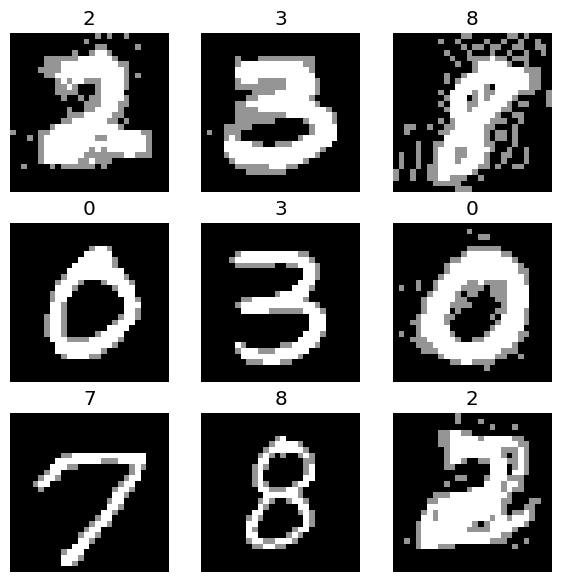

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[umbralizacion_tri]

)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

Número total de imágenes en entrenamiento: 21714
Número total de imágenes en validación: 11996

Clases: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


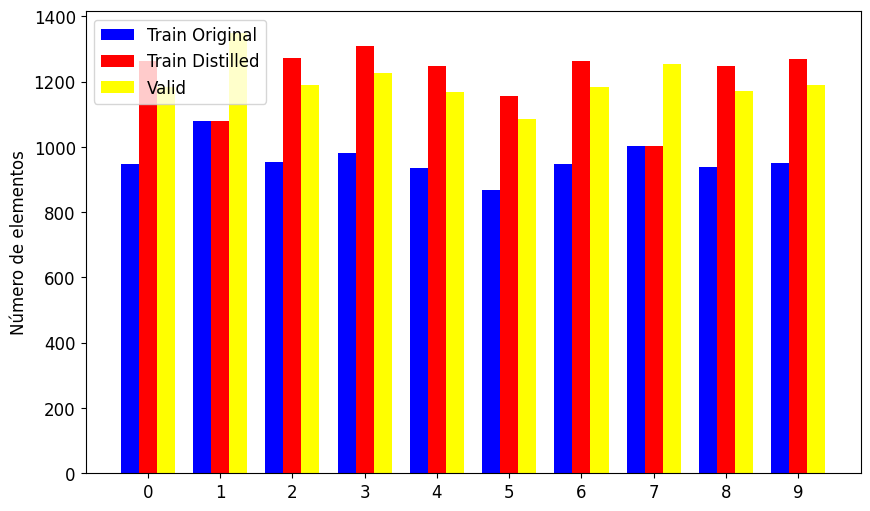

In [ ]:
# Obtener el número total de imágenes
num_train = len(dls.train_ds)
num_valid = len(dls.valid_ds)

print(f"Número total de imágenes en entrenamiento: {num_train}")
print(f"Número total de imágenes en validación: {num_valid}")

# Obtener la distribución de clases
class_counts = dls.train_ds.vocab  # Obtiene las clases
print("\nClases:", class_counts)

plot_label_counts(dls)

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])


In [ ]:
start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.303124,2.304667,0.098700,0.100000,0.017967,00:33
1,2.302429,2.303303,0.098616,0.100000,0.017953,00:34
2,2.301556,2.303346,0.098616,0.100000,0.017953,00:34
3,1.723368,1.697329,0.394465,0.389701,0.342908,00:33
4,0.669115,0.873658,0.712821,0.708509,0.702680,00:35
5,0.464329,0.706117,0.769256,0.767647,0.767230,00:33
6,0.364637,0.589793,0.815522,0.813445,0.810951,00:35
7,0.312101,0.499836,0.844782,0.841933,0.842191,00:33
8,0.251968,0.419131,0.874875,0.873775,0.872890,00:34
9,0.239386,0.367860,0.889296,0.887905,0.887581,00:33



Tiempo de entrenamiento: 688.72 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.2379
Accuracy: 0.9286
Recall: 0.9279
F1-Score: 0.9278


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral01_0001_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[umbralizacion_tri]
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral01_0001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.216669961810112
Accuracy: 0.9354968070983887
Recall (macro): 0.9347450174397492
F1 Score (macro): 0.9346994811599167


### Lenet 0001 - Example 2

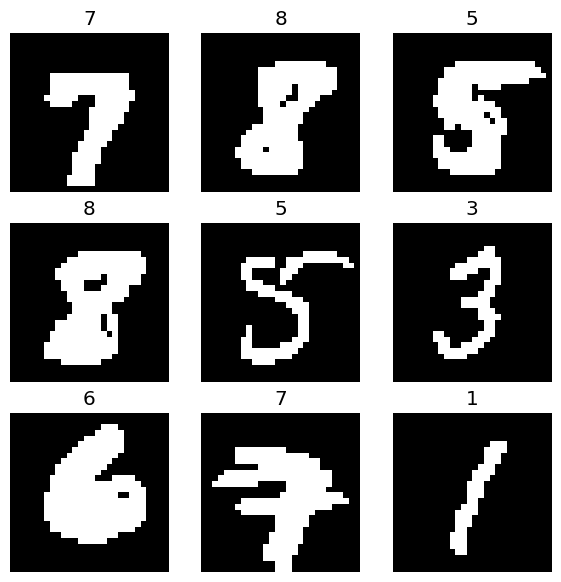

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[umbralizacion_bi]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,2.303934,2.303518,0.099116,0.100000,0.018036,00:33
1,2.302501,2.302723,0.099283,0.100000,0.018063,00:34
2,2.302326,2.302764,0.102201,0.100000,0.018545,00:33
3,2.302753,2.303439,0.099116,0.100000,0.018036,00:34
4,2.259681,2.180270,0.216989,0.205327,0.128773,00:50
5,1.020147,1.118219,0.625709,0.620742,0.620238,00:58
6,0.633179,0.875395,0.709737,0.705951,0.705910,01:05
7,0.530209,0.748970,0.761420,0.758433,0.759654,00:56
8,0.452492,0.670601,0.786762,0.784137,0.783407,01:01
9,0.391035,0.615182,0.809853,0.807237,0.805447,00:59



Tiempo de entrenamiento: 958.68 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.4236
Accuracy: 0.8717
Recall: 0.8701
F1-Score: 0.8699


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral02_0001_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[umbralizacion_bi]
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral02_0001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.39274299144744873
Accuracy: 0.8775039911270142
Recall (macro): 0.8758013715027172
F1 Score (macro): 0.8755024095766032


### Lenet 0001 - Example 3

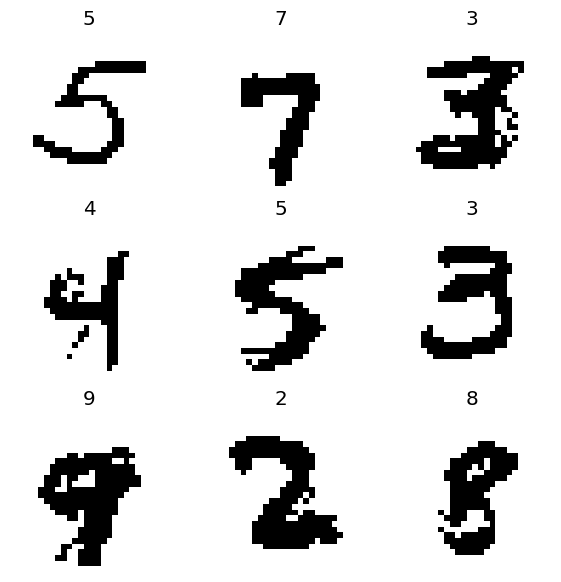

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[otsu_threshold_transform]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
model = LeNet(num_classes=10)
# Crear el objeto learn
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])

start_time = time.time()
learn.fit_one_cycle(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.598480,1.335290,0.667139,0.658782,0.642950,00:36
1,0.336825,0.507051,0.845115,0.843584,0.843635,00:35
2,0.199995,0.338220,0.893881,0.892413,0.892582,00:36
3,0.149796,0.243237,0.926559,0.924861,0.925410,00:35
4,0.104368,0.169749,0.947733,0.947218,0.947200,00:36
5,0.092062,0.136491,0.957903,0.957595,0.957409,00:34
6,0.073779,0.127528,0.960737,0.960335,0.960461,00:36
7,0.056953,0.107033,0.967739,0.967479,0.967459,00:34
8,0.047271,0.105673,0.970073,0.969961,0.969754,00:36
9,0.037595,0.101948,0.971074,0.970887,0.970779,00:35


No improvement since epoch 14: early stopping

Tiempo de entrenamiento: 726.71 segundos


In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0966
Accuracy: 0.9773
Recall: 0.9772
F1-Score: 0.9771


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral03_0001_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=IndexSplitter([]),
    item_tfms=[otsu_threshold_transform]
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing', bs=64)

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/lenet_distilled__umbral03_0001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.08635666221380234
Accuracy: 0.9793669581413269
Recall (macro): 0.979283061798952
F1 Score (macro): 0.9792452374407155


## Resnet 001

In [13]:
def umbralizacion_tri(img: PILImage):
    img_quant = img.quantize(colors=3).convert("L")
    arr = np.array(img_quant)
    arr_rgb = np.stack([arr]*3, axis=-1)            # Triplicamos el canal (H, W) -> (H, W, 3)
    return Image.fromarray(arr_rgb.astype('uint8'))


In [14]:
def umbralizacion_bi(img: PILImage):
    img_quant = img.quantize(colors=2).convert("L")
    arr = np.array(img_quant)
    arr_rgb = np.stack([arr]*3, axis=-1)            # Triplicamos el canal (H, W) -> (H, W, 3)
    return Image.fromarray(arr_rgb.astype('uint8'))


In [15]:
import cv2

def otsu_threshold_transform(img: PILImage):
    img_array = np.array(img.convert("L"))
    _, thresholded = cv2.threshold(img_array, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thresholded_rgb = np.stack([thresholded] * 3, axis=-1)  # Triplica el canal
    return PILImage.create(thresholded_rgb)


In [16]:
dst = base_path / "distilled_001"

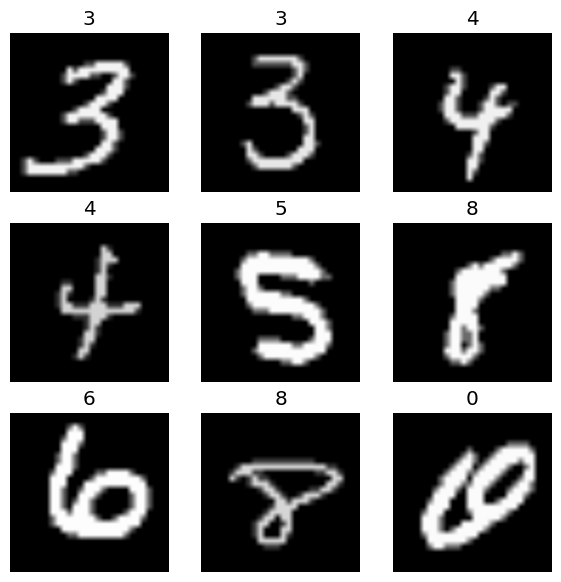

In [17]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[umbralizacion_tri, Resize(224)]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [18]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=10)])


In [19]:
start_time = time.time()
#learn.fit_one_cycle(20)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.710058,0.817673,0.729993,0.725387,0.724910,01:00


epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.572538,0.384239,0.877959,0.877019,0.876178,01:10
1,0.232075,0.338154,0.898383,0.897892,0.898708,01:08
2,0.105947,0.233567,0.929560,0.929054,0.928487,01:07
3,0.087887,0.292814,0.918890,0.917085,0.918998,01:07
4,0.077793,0.357115,0.909303,0.908175,0.908733,01:07
5,0.067960,0.149021,0.958820,0.958419,0.958579,01:08
6,0.052218,0.249665,0.942564,0.942079,0.942373,01:08
7,0.045309,0.141305,0.963988,0.963608,0.963403,01:07
8,0.036911,0.148219,0.962488,0.961890,0.961569,01:07
9,0.023673,0.284941,0.934395,0.933408,0.933727,01:07



Tiempo de entrenamiento: 1418.43 segundos


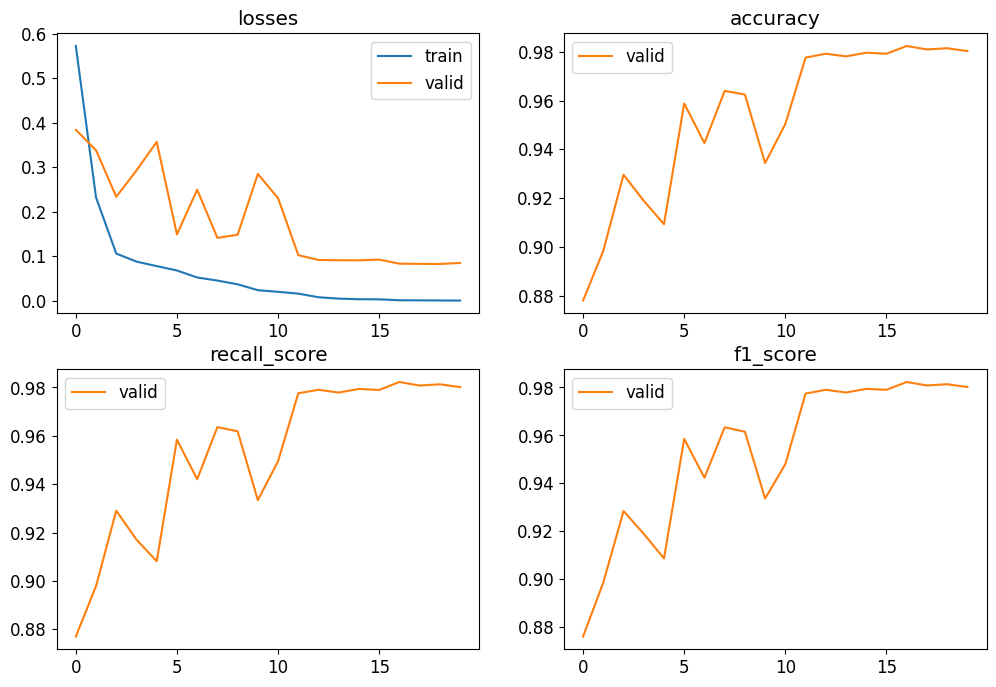

In [20]:
learn.recorder.plot_metrics()

In [21]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0849
Accuracy: 0.9803
Recall: 0.9802
F1-Score: 0.9802


In [22]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral01_001_v3.pkl')

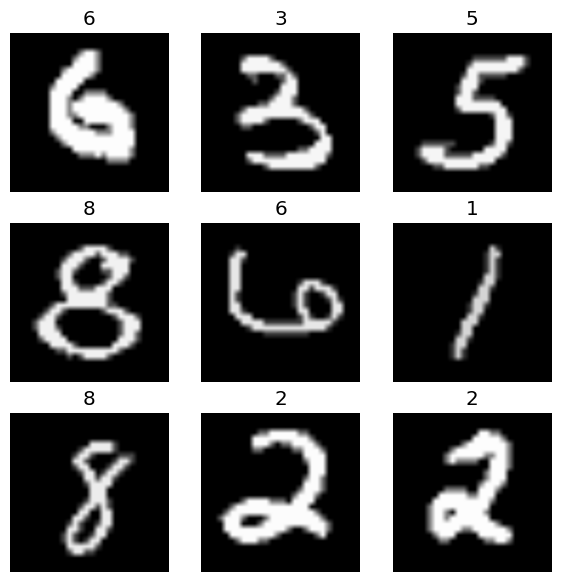

In [23]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[umbralizacion_tri, Resize(224)],
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing')

test_dls.show_batch(max_n=9, figsize=(7,7))

In [24]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral01_001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [25]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.0796934962272644
Accuracy: 0.9787660241127014
Recall (macro): 0.9785761038166191
F1 Score (macro): 0.978597830173436


### Resnet 001 - Example 2

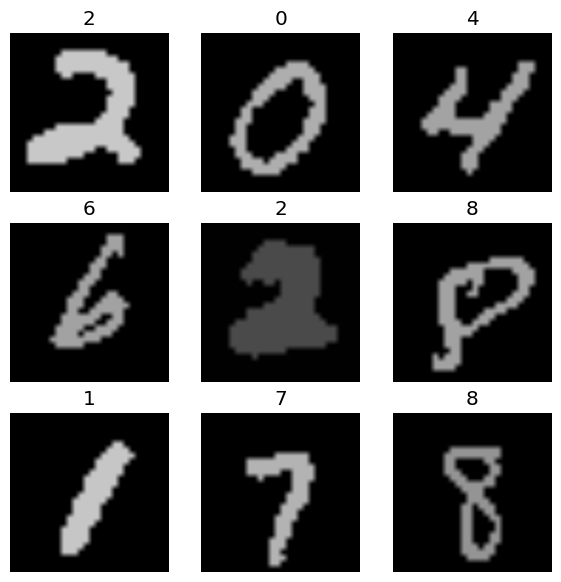

In [26]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_bi]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [27]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])


In [28]:
start_time = time.time()
#learn.fit_one_cycle(20)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.880821,1.094301,0.632127,0.626449,0.625983,01:00


epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.706127,0.512120,0.833611,0.832251,0.833647,01:07
1,0.314283,0.349203,0.886629,0.885490,0.885306,01:07
2,0.140008,0.326968,0.900967,0.900016,0.900417,01:07
3,0.115417,1.161271,0.749416,0.744112,0.736144,01:07
4,0.083807,0.568473,0.853785,0.851645,0.859814,01:08
5,0.070782,0.418707,0.893548,0.893536,0.891850,01:07
6,0.050687,0.338326,0.920223,0.919388,0.917253,01:07
7,0.039585,0.196099,0.950484,0.949963,0.949809,01:07
8,0.029959,0.175171,0.953735,0.953501,0.953549,01:09
9,0.030240,0.201955,0.948816,0.948059,0.948351,01:07



Tiempo de entrenamiento: 1414.75 segundos


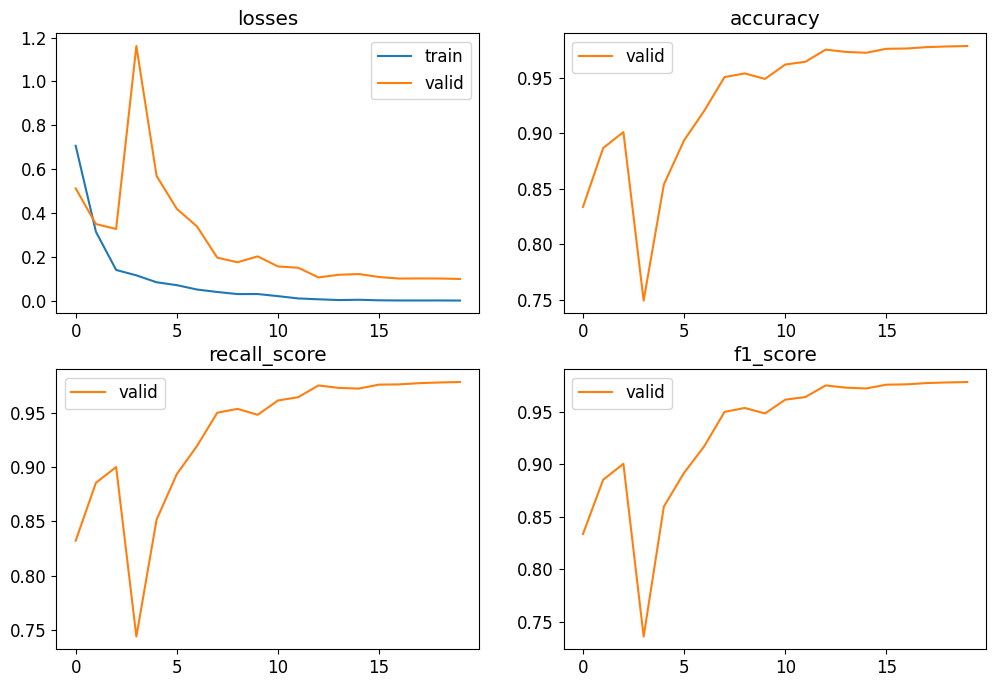

In [29]:
learn.recorder.plot_metrics()

In [30]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0989
Accuracy: 0.9784
Recall: 0.9782
F1-Score: 0.9782


In [31]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral02_001_v3.pkl')

In [32]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_bi],
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing')

In [33]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral02_001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [34]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.09864611178636551
Accuracy: 0.9778645634651184
Recall (macro): 0.9776395825770127
F1 Score (macro): 0.977716147246588


### Resnet 001 - Example 3

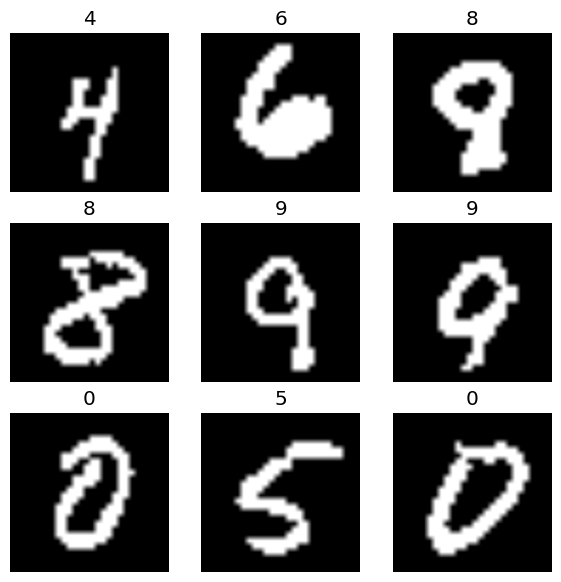

In [35]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224), otsu_threshold_transform]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [36]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=10)])


In [37]:
start_time = time.time()
#learn.fit_one_cycle(20)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.444645,0.818945,0.728660,0.724656,0.721995,01:01


epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.516555,0.387354,0.875542,0.873538,0.873847,01:06
1,0.218956,0.262912,0.918556,0.917529,0.917507,01:06
2,0.109244,0.264141,0.924141,0.922779,0.923133,01:07
3,0.082758,0.353389,0.906052,0.905808,0.906843,01:06
4,0.078175,0.298844,0.922641,0.920719,0.923494,01:06
5,0.076593,0.241857,0.939230,0.938282,0.938652,01:07
6,0.046972,0.463144,0.887796,0.886766,0.892144,01:06
7,0.040582,1.297570,0.783178,0.780753,0.800867,01:06
8,0.033455,0.150574,0.964738,0.964572,0.964370,01:06
9,0.020455,0.142314,0.965989,0.965665,0.965780,01:06



Tiempo de entrenamiento: 1395.24 segundos


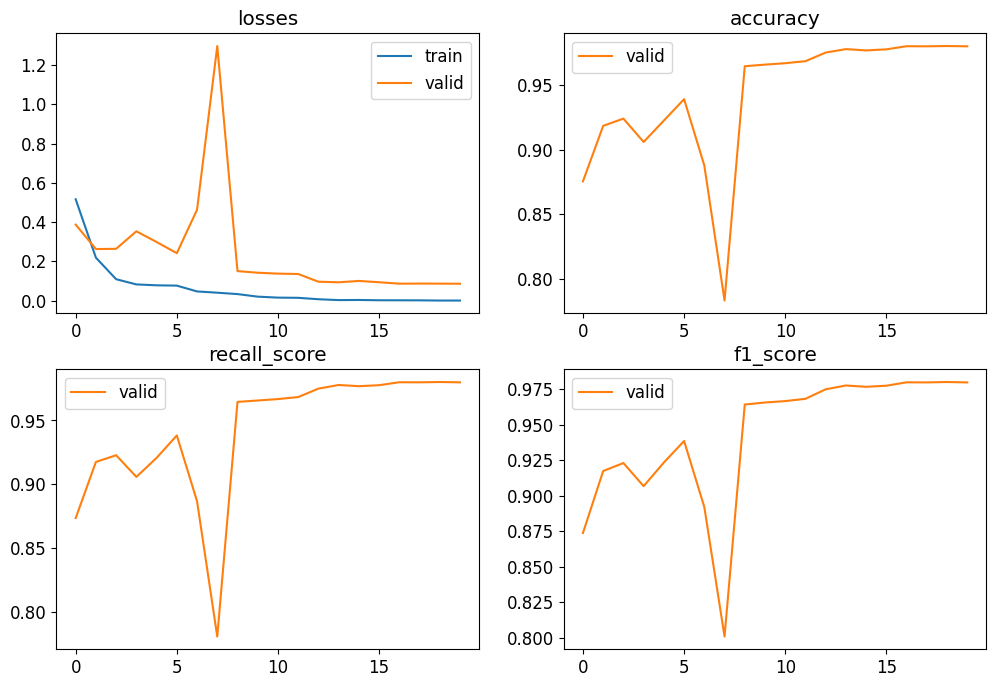

In [38]:
learn.recorder.plot_metrics()

In [39]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0863
Accuracy: 0.9802
Recall: 0.9799
F1-Score: 0.9799


In [40]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral03_001_v3.pkl')

In [41]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[Resize(224), otsu_threshold_transform],
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing')

In [42]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral03_001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [43]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.07519232481718063
Accuracy: 0.9800680875778198
Recall (macro): 0.9797709489524381
F1 Score (macro): 0.979856629378871


## Resnet 005

In [44]:
dst = base_path / "distilled_005"

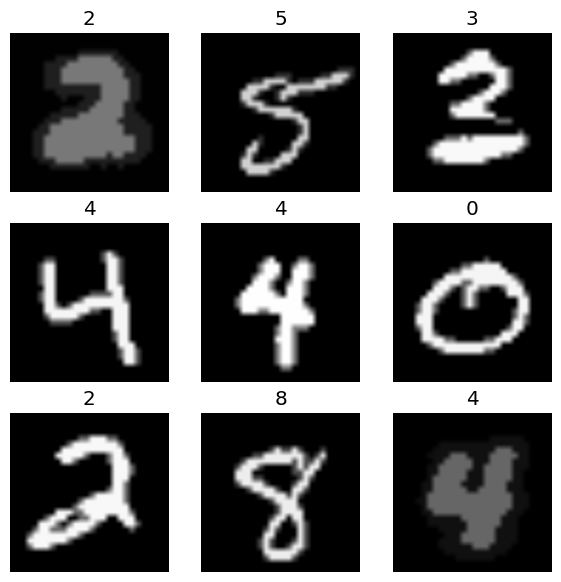

In [45]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_tri]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [46]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=10)])


In [47]:
start_time = time.time()
#learn.fit_one_cycle(60)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.653085,0.874346,0.704568,0.699168,0.696341,00:59


epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.650833,0.384031,0.876375,0.874318,0.874394,01:04
1,0.274408,0.335789,0.893715,0.890620,0.891643,01:04
2,0.131757,0.409021,0.878960,0.878755,0.874233,01:05
3,0.085313,0.293221,0.919056,0.917836,0.917431,01:04
4,0.094160,1.932485,0.698983,0.690777,0.711856,01:04
5,0.071683,0.220164,0.937813,0.936360,0.937477,01:04
6,0.050786,0.400294,0.895715,0.893932,0.895805,01:04
7,0.039888,0.292855,0.924308,0.924889,0.923347,01:04
8,0.028932,0.166618,0.959320,0.959007,0.958740,01:04
9,0.030539,0.261861,0.938563,0.937716,0.937609,01:04



Tiempo de entrenamiento: 1358.23 segundos


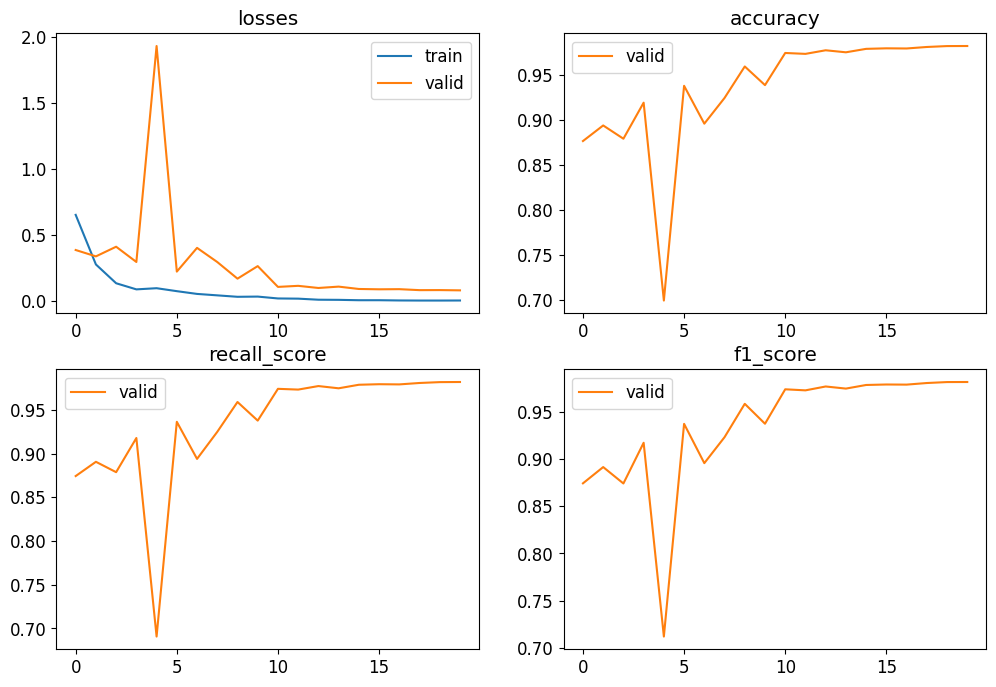

In [48]:
learn.recorder.plot_metrics()

In [49]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0779
Accuracy: 0.9821
Recall: 0.9819
F1-Score: 0.9819


In [50]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral01_005_v3.pkl')

In [51]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_tri],
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing')

In [52]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral01_005_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [53]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.07699429243803024
Accuracy: 0.979567289352417
Recall (macro): 0.9793047439059641
F1 Score (macro): 0.9793418863707531


### Resnet 005 - Example 2

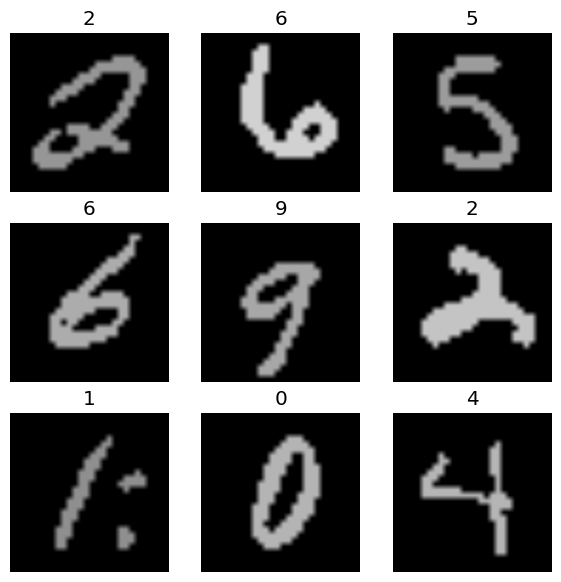

In [54]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_bi]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [55]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=10)])


In [56]:
start_time = time.time()
#learn.fit_one_cycle(20)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time


KeyboardInterrupt: 

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral02_005_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_bi],
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing')

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral02_005_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

### Resnet 005 - Example 3

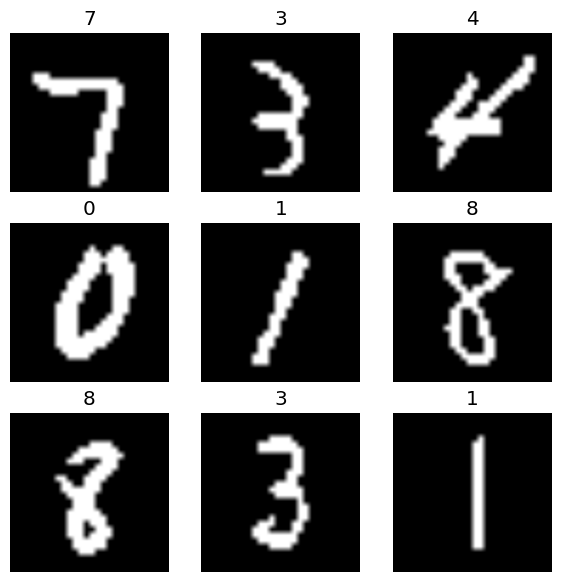

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224), otsu_threshold_transform]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=10)])


In [ ]:
start_time = time.time()
#learn.fit_one_cycle(20)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.399631,0.727254,0.760253,0.756440,0.754799,00:57


epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.489640,0.336667,0.893214,0.891177,0.892169,01:03
1,0.206438,0.265340,0.915805,0.914310,0.915255,01:04
2,0.104515,0.282192,0.916055,0.913383,0.914035,01:03
3,0.078769,0.308861,0.917056,0.916660,0.916554,01:03
4,0.072560,0.277224,0.926809,0.927107,0.926688,01:04
5,0.062334,0.233191,0.939897,0.939794,0.939112,01:03
6,0.049225,0.176288,0.955485,0.955531,0.955238,01:04
7,0.046037,0.215958,0.944815,0.944190,0.944672,01:03
8,0.025205,0.129320,0.970073,0.969786,0.969788,01:03
9,0.024599,0.186419,0.956819,0.956332,0.956894,01:03



Tiempo de entrenamiento: 1333.17 segundos


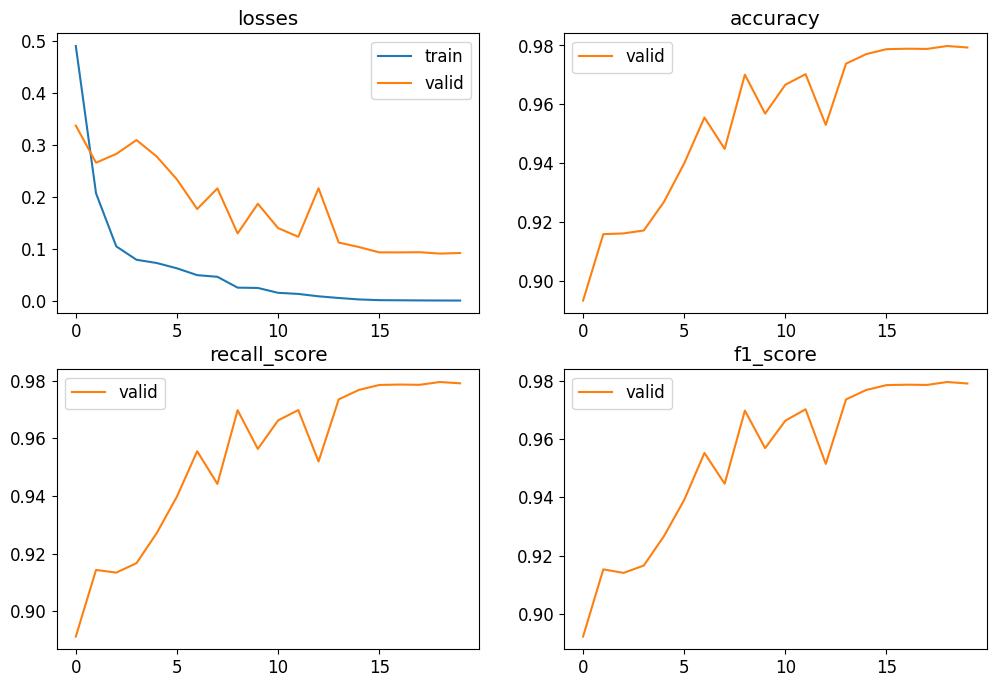

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0918
Accuracy: 0.9793
Recall: 0.9791
F1-Score: 0.9791


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral03_005_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[Resize(224), otsu_threshold_transform],
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing')

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral03_005_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 0.07778642326593399
Accuracy: 0.9792668223381042
Recall (macro): 0.9791232026286059
F1 Score (macro): 0.9790859458360883


## Resnet 0001

In [ ]:
dst = base_path / "distilled_0001"

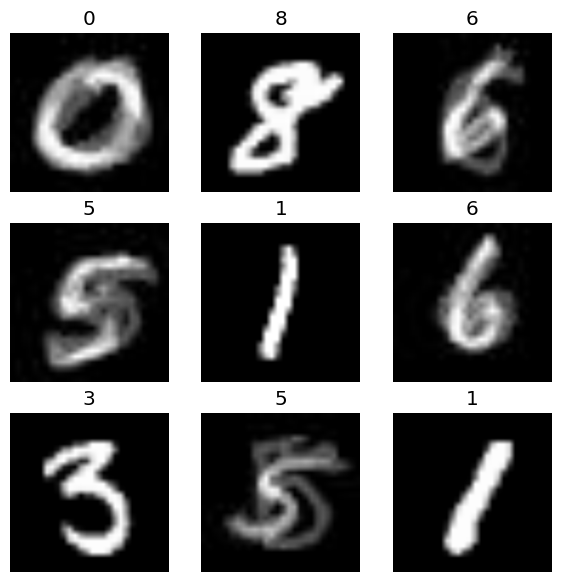

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[umbralizacion_tri, Resize(224)]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5)])


In [ ]:
start_time = time.time()
#learn.fit_one_cycle(20)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.132437,0.821896,0.724908,0.720498,0.720597,01:35


epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.227492,0.283366,0.914888,0.914134,0.914140,01:48
1,0.096582,0.181623,0.947399,0.946984,0.947086,01:48
2,0.057821,0.200460,0.943731,0.943475,0.943748,01:48
3,0.055904,0.166517,0.954151,0.954002,0.953941,01:49
4,0.044107,0.196717,0.946399,0.945731,0.945677,01:48
5,0.045916,0.250046,0.933394,0.932842,0.931828,01:48
6,0.025223,0.130139,0.966489,0.966319,0.966565,01:47
7,0.023598,0.149509,0.963154,0.962475,0.962657,01:48
8,0.015607,0.098258,0.976742,0.976268,0.976337,01:48
9,0.012247,0.130007,0.968323,0.967057,0.967581,01:48



Tiempo de entrenamiento: 2259.64 segundos


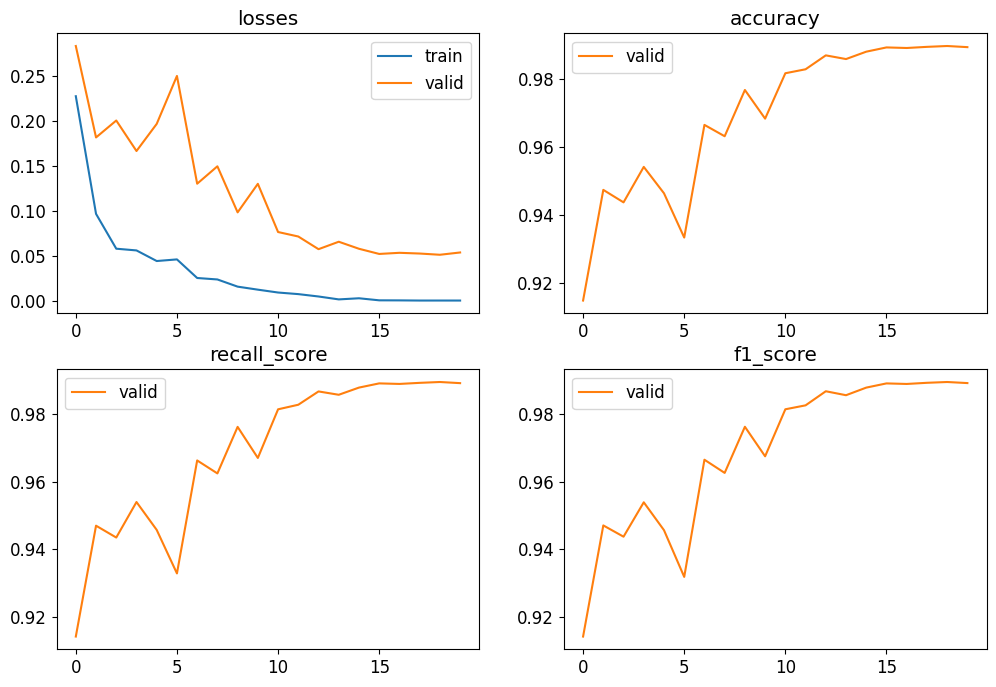

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 0.0536
Accuracy: 0.9893
Recall: 0.9892
F1-Score: 0.9893


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral01_0001_v3.pkl')

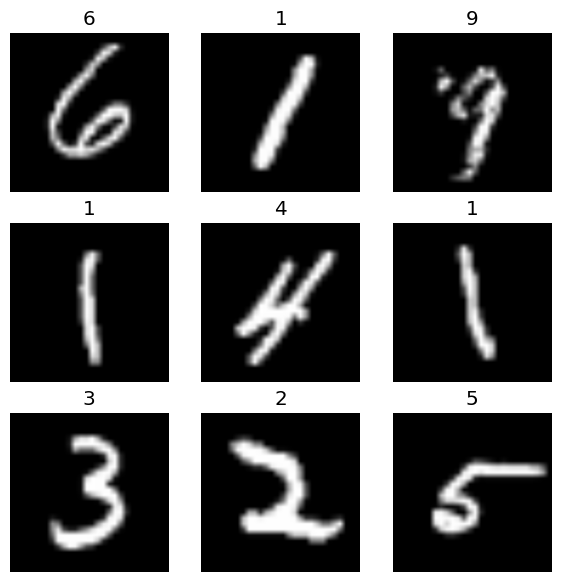

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[umbralizacion_tri, Resize(224)],
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing')

test_dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral01_0001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

### Resnet 0001 - Example 2

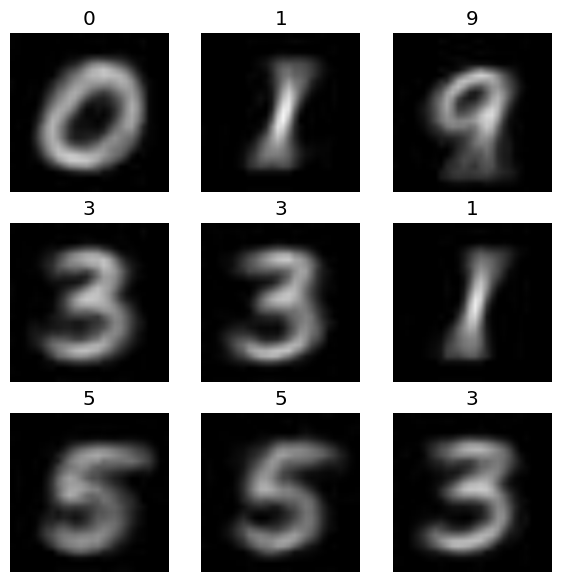

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_bi]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=10)])


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.5MB/s]


In [ ]:
start_time = time.time()
#learn.fit_one_cycle(20)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.600949,4.076629,0.211409,0.205739,0.154199,00:08


epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.020374,3.431494,0.226510,0.225278,0.168860,00:08
1,0.011771,3.045543,0.312081,0.302937,0.217840,00:09
2,0.007347,3.515675,0.270134,0.264038,0.203080,00:09
3,0.004870,3.690595,0.303691,0.294617,0.204133,00:08
4,0.003322,4.112275,0.286913,0.277520,0.172041,00:06
5,0.002624,4.326322,0.276846,0.267932,0.152107,00:06
6,0.002021,4.671216,0.280201,0.270630,0.162756,00:06
7,0.001480,4.758033,0.280201,0.270600,0.161558,00:06
8,0.001101,4.783267,0.273490,0.264225,0.157904,00:04
9,0.000832,4.951801,0.255034,0.247230,0.159905,00:05


No improvement since epoch 1: early stopping

Tiempo de entrenamiento: 91.90 segundos


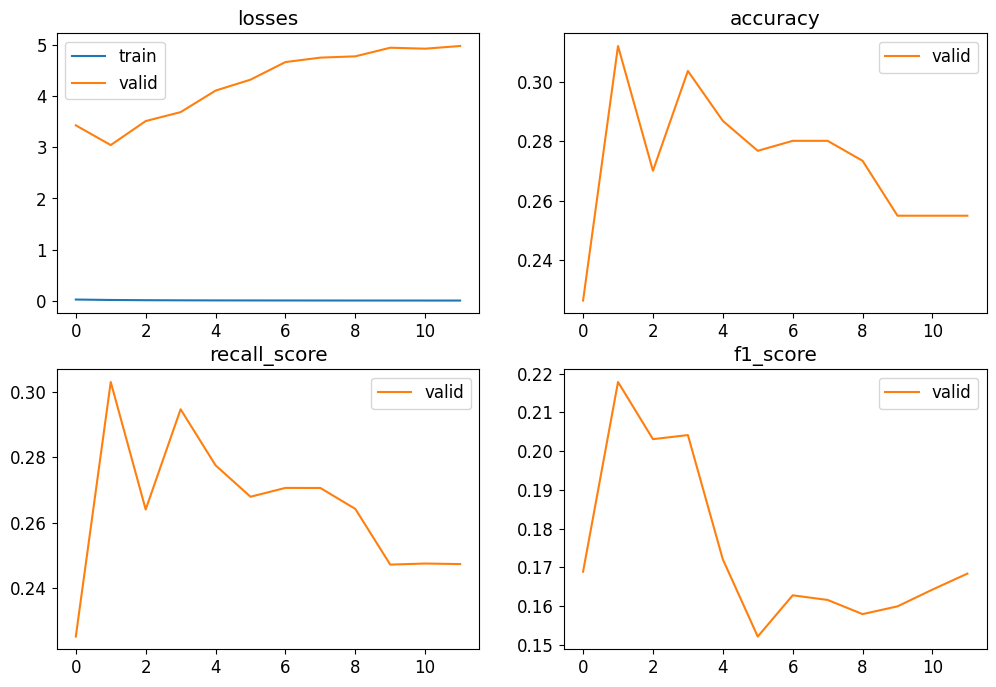

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 4.9857
Accuracy: 0.2550
Recall: 0.2474
F1-Score: 0.1684


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral03_0001_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[Resize(224), umbralizacion_bi],
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing')

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral03_0001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.473205089569092
Accuracy: 0.12299679219722748
Recall (macro): 0.1264540437826184
F1 Score (macro): 0.08181593224962938


### Resnet 0001 - Example 3

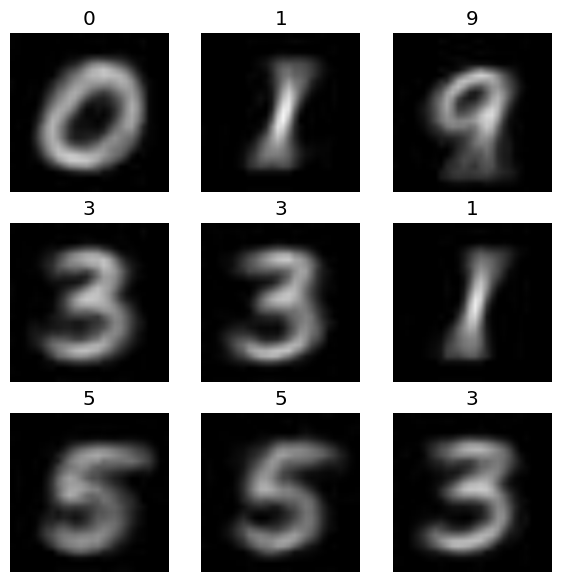

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224), otsu_threshold_transform]
)

dls = dblock.dataloaders(dst, bs=64)

dls.show_batch(max_n=9, figsize=(7,7))

In [ ]:
learn = vision_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, Recall(average='macro'), F1Score(average='macro')], pretrained=False, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=10)])


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.5MB/s]


In [ ]:
start_time = time.time()
#learn.fit_one_cycle(20)
learn.fine_tune(20)
end_time = time.time()

print(f"\nTiempo de entrenamiento: {end_time - start_time:.2f} segundos")

epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,1.600949,4.076629,0.211409,0.205739,0.154199,00:08


epoch,train_loss,valid_loss,accuracy,recall_score,f1_score,time
0,0.020374,3.431494,0.226510,0.225278,0.168860,00:08
1,0.011771,3.045543,0.312081,0.302937,0.217840,00:09
2,0.007347,3.515675,0.270134,0.264038,0.203080,00:09
3,0.004870,3.690595,0.303691,0.294617,0.204133,00:08
4,0.003322,4.112275,0.286913,0.277520,0.172041,00:06
5,0.002624,4.326322,0.276846,0.267932,0.152107,00:06
6,0.002021,4.671216,0.280201,0.270630,0.162756,00:06
7,0.001480,4.758033,0.280201,0.270600,0.161558,00:06
8,0.001101,4.783267,0.273490,0.264225,0.157904,00:04
9,0.000832,4.951801,0.255034,0.247230,0.159905,00:05


No improvement since epoch 1: early stopping

Tiempo de entrenamiento: 91.90 segundos


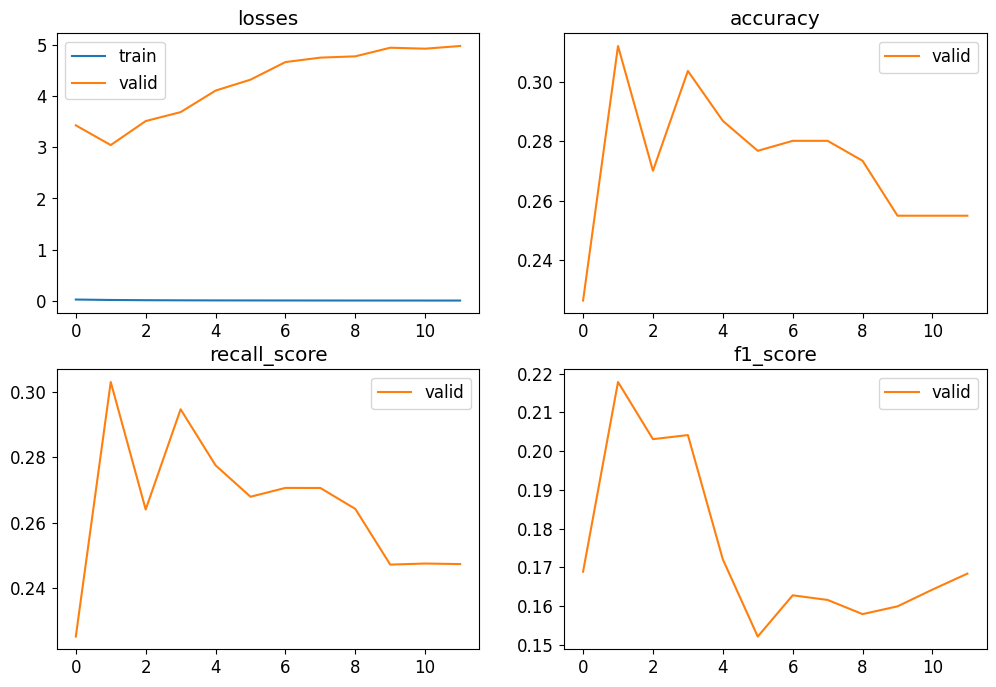

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
loss, acc, recall, f1 = learn.validate()

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f"Recall: {recall:.4f}")
print(f'F1-Score: {f1:.4f}')

Loss: 4.9857
Accuracy: 0.2550
Recall: 0.2474
F1-Score: 0.1684


In [ ]:
learn.export('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral03_0001_v3.pkl')

In [ ]:
test_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=[Resize(224), otsu_threshold_transform]
    splitter=IndexSplitter([])
)

test_dls = test_block.dataloaders(original_path/'mnist_png'/'testing')

In [ ]:
learn = load_learner('/content/drive/MyDrive/TFG/modelos/resnet_distilled__umbral03_0001_v3.pkl')
learn.remove_cb(EarlyStoppingCallback)

In [ ]:
loss, acc, recall, f1 = learn.validate(dl=test_dls.train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")

Loss: 4.473205089569092
Accuracy: 0.12299679219722748
Recall (macro): 0.1264540437826184
F1 Score (macro): 0.08181593224962938
